# Import

In [4]:
import pickle
path1=""
path2=""
with open(path1, 'rb') as fo:
    train_data_full = pickle.load(fo,encoding="latin-1")
with open(path2, 'rb') as fo:
    test_data_full = pickle.load(fo,encoding="latin-1")

In [5]:
print(len(train_data_full["filenames"]),len(test_data_full["filenames"]))

50000 10000


In [6]:
train_data_full.keys()

dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])

In [7]:
print(train_data_full["filenames"][0])
print(train_data_full["batch_label"][0])
print(train_data_full["fine_labels"][0])
print(train_data_full["coarse_labels"][0])
print(train_data_full["data"][0])

bos_taurus_s_000507.png
t
19
11
[255 255 255 ...  10  59  79]


# Data division

In [8]:
x_train = train_data_full["data"]
y_train = train_data_full["fine_labels"]

In [9]:
print(len(x_train),len(y_train))

50000 50000


In [10]:
from sklearn.model_selection import train_test_split

r = 0.2
x_subtrain_raw, x_val_raw, y_subtrain_raw, y_val_raw = train_test_split(x_train, y_train, test_size=r)

### Train and evaluate data

In [11]:
print(len(x_subtrain_raw),len(y_subtrain_raw),len(x_val_raw),len(y_val_raw))

40000 40000 10000 10000


In [12]:
len(x_subtrain_raw[0])

3072

In [13]:
import numpy as np
def shaping(array):
    #print(array[0:1024])
    #print(array[1024:2048])
    #print(array[2048:3072]) #just showing the 3 channels
    reshaped = array.reshape(3,1024) #we create a 3*1024 dimensionality for the 3 color channels
    red_channel = reshaped[0].reshape(32, 32)
    green_channel = reshaped[1].reshape(32, 32)
    blue_channel = reshaped[2].reshape(32, 32) #for each channel, we turn the 1024 into 2 dimensions of 32*32.
    ##print(red_channel.shape,red_channel) #printing for verification
    x_reshaped = np.stack((red_channel,green_channel,blue_channel),axis=2)
    #print(x_subtrain.shape) #printing shape which should be 32 * 32 * 3
    return x_reshaped

In [14]:
x_subtrain_raw = [x/255 for x in x_subtrain_raw] 
x_val_raw = [x/255 for x in x_val_raw]

In [15]:
x_subtrain = [shaping(x) for x in x_subtrain_raw]
x_val = [shaping(x) for x in x_val_raw]

In [16]:
print(len(x_subtrain),x_subtrain[0].shape)
print(len(x_val),x_val[0].shape)
x_subtrain = np.stack(x_subtrain,axis=0)
x_val = np.stack(x_val,axis=0)
print(x_subtrain.shape,x_val.shape)

40000 (32, 32, 3)
10000 (32, 32, 3)
(40000, 32, 32, 3) (10000, 32, 32, 3)


In [17]:
from keras.utils import to_categorical

y_subtrain = to_categorical(y_subtrain_raw, 100)
y_val = to_categorical(y_val_raw, 100)

In [18]:
y_subtrain[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### Test data

In [19]:
from keras.utils import to_categorical

x_test_raw = test_data_full["data"]
y_test_raw = test_data_full["fine_labels"]

x_test_raw = [x/255 for x in x_test_raw] 
x_test = [shaping(x) for x in x_test_raw]

x_test = np.stack(x_test,axis=0)
y_test = to_categorical(y_test_raw, 100)

# Models

In [31]:
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from keras.regularizers import l2


### Model 1

In [115]:
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(1024, activation='relu'))
model1.add(layers.Dense(100, activation='softmax'))

model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_119 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 4, 4, 64)          36928     
                                                                 
 flatten_23 (Flatten)        (None, 1024)            

In [116]:
history1 = model1.fit(x_subtrain, y_subtrain, batch_size=100, epochs=10,validation_split=0.2)


Epoch 1/10
320/320 [==============================] - 15s 43ms/step - loss: 3.9580 - accuracy: 0.0966 - val_loss: 3.5589 - val_accuracy: 0.1612
Epoch 2/10
320/320 [==============================] - 14s 43ms/step - loss: 3.3094 - accuracy: 0.2023 - val_loss: 3.1763 - val_accuracy: 0.2323
Epoch 3/10
320/320 [==============================] - 14s 44ms/step - loss: 2.9687 - accuracy: 0.2652 - val_loss: 2.9754 - val_accuracy: 0.2656
Epoch 4/10
320/320 [==============================] - 15s 45ms/step - loss: 2.7099 - accuracy: 0.3194 - val_loss: 2.8811 - val_accuracy: 0.2896
Epoch 5/10
320/320 [==============================] - 14s 44ms/step - loss: 2.4767 - accuracy: 0.3612 - val_loss: 2.8763 - val_accuracy: 0.2931
Epoch 6/10
320/320 [==============================] - 13s 42ms/step - loss: 2.2582 - accuracy: 0.4106 - val_loss: 2.7704 - val_accuracy: 0.3175
Epoch 7/10
320/320 [==============================] - 14s 42ms/step - loss: 2.0182 - accuracy: 0.4602 - val_loss: 2.7881 - val_accuracy:

In [117]:
model1.save("model1.keras")

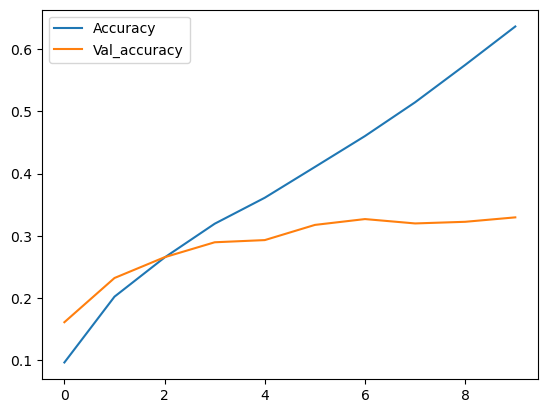

In [123]:
plt.plot(history1.history["accuracy"])
plt.plot(history1.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])

### Model 2 

In [119]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",input_shape=(32, 32, 3)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3),padding="same" ,activation='relu'))
model2.add(layers.Conv2D(64, (3, 3),padding="same" ,activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3),padding="same" ,activation='relu'))
model2.add(layers.Conv2D(128, (3, 3),padding="same" ,activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(100, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_122 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_123 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_124 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

In [120]:
history2 = model2.fit(x_subtrain, y_subtrain, batch_size=100, epochs=10,validation_split=0.2)


Epoch 1/10
320/320 [==============================] - 46s 141ms/step - loss: 4.2059 - accuracy: 0.0518 - val_loss: 3.7344 - val_accuracy: 0.1252
Epoch 2/10
320/320 [==============================] - 45s 142ms/step - loss: 3.4978 - accuracy: 0.1681 - val_loss: 3.3579 - val_accuracy: 0.2020
Epoch 3/10
320/320 [==============================] - 45s 142ms/step - loss: 3.0426 - accuracy: 0.2502 - val_loss: 3.0751 - val_accuracy: 0.2544
Epoch 4/10
320/320 [==============================] - 46s 142ms/step - loss: 2.6763 - accuracy: 0.3254 - val_loss: 2.8882 - val_accuracy: 0.2954
Epoch 5/10
320/320 [==============================] - 46s 144ms/step - loss: 2.3057 - accuracy: 0.4062 - val_loss: 2.8769 - val_accuracy: 0.3116
Epoch 6/10
320/320 [==============================] - 46s 144ms/step - loss: 1.9313 - accuracy: 0.4854 - val_loss: 2.8911 - val_accuracy: 0.3217
Epoch 7/10
320/320 [==============================] - 45s 142ms/step - loss: 1.5174 - accuracy: 0.5833 - val_loss: 3.2548 - val_ac

In [121]:
model2.save("model2.keras")

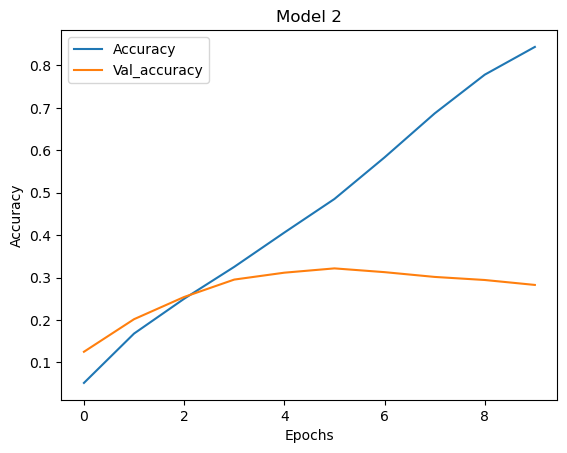

In [127]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 2");

### Model 3

In [128]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",input_shape=(32, 32, 3)))
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3),padding="same" ,activation='relu'))
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv2D(64, (3, 3),padding="same" ,activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3),padding="same" ,activation='relu'))
model3.add(layers.Conv2D(128, (3, 3),padding="same" ,activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(1024, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(100, activation='softmax'))

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 dropout_38 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_128 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_51 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, 16, 16, 64)      

In [129]:
history3 = model3.fit(x_subtrain, y_subtrain, batch_size=100, epochs=10,validation_split=0.2)


Epoch 1/10
320/320 [==============================] - 73s 224ms/step - loss: 4.0553 - accuracy: 0.0827 - val_loss: 4.8853 - val_accuracy: 0.0196
Epoch 2/10
320/320 [==============================] - 71s 221ms/step - loss: 3.4081 - accuracy: 0.1828 - val_loss: 3.4746 - val_accuracy: 0.1759
Epoch 3/10
320/320 [==============================] - 71s 221ms/step - loss: 2.9637 - accuracy: 0.2658 - val_loss: 3.1308 - val_accuracy: 0.2459
Epoch 4/10
320/320 [==============================] - 72s 225ms/step - loss: 2.5131 - accuracy: 0.3555 - val_loss: 3.0374 - val_accuracy: 0.2729
Epoch 5/10
320/320 [==============================] - 72s 226ms/step - loss: 1.9913 - accuracy: 0.4685 - val_loss: 3.2997 - val_accuracy: 0.2630
Epoch 6/10
320/320 [==============================] - 72s 224ms/step - loss: 1.3427 - accuracy: 0.6242 - val_loss: 3.8689 - val_accuracy: 0.2599
Epoch 7/10
320/320 [==============================] - 71s 222ms/step - loss: 0.7880 - accuracy: 0.7695 - val_loss: 4.4538 - val_ac

In [130]:
model3.save("model3.keras")

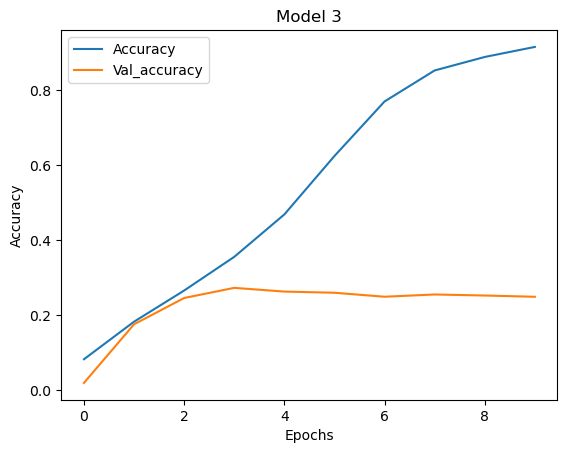

In [131]:
plt.plot(history3.history["accuracy"])
plt.plot(history3.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 3");

### Model 4

In [132]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",input_shape=(32, 32, 3)))
model4.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3),padding="same" ,activation='relu'))
model4.add(layers.Conv2D(64, (3, 3),padding="same" ,activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3),padding="same" ,activation='relu'))
model4.add(layers.Conv2D(128, (3, 3),padding="same" ,activation='relu'))
model4.add(layers.Flatten())
model4.add(layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.001)))
model4.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
model4.add(layers.Dense(100, activation='softmax'))

model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_133 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_134 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_135 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_136 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

In [133]:
history4 = model4.fit(x_subtrain, y_subtrain, batch_size=100, epochs=10,validation_split=0.2)

Epoch 1/10
320/320 [==============================] - 65s 199ms/step - loss: 4.3929 - accuracy: 0.0399 - val_loss: 4.0218 - val_accuracy: 0.0845
Epoch 2/10
320/320 [==============================] - 62s 193ms/step - loss: 3.8775 - accuracy: 0.1088 - val_loss: 3.7164 - val_accuracy: 0.1390
Epoch 3/10
320/320 [==============================] - 63s 198ms/step - loss: 3.5607 - accuracy: 0.1679 - val_loss: 3.4134 - val_accuracy: 0.1965
Epoch 4/10
320/320 [==============================] - 63s 196ms/step - loss: 3.2869 - accuracy: 0.2259 - val_loss: 3.2770 - val_accuracy: 0.2359
Epoch 5/10
320/320 [==============================] - 63s 197ms/step - loss: 3.0715 - accuracy: 0.2783 - val_loss: 3.1910 - val_accuracy: 0.2545
Epoch 6/10
320/320 [==============================] - 62s 194ms/step - loss: 2.8885 - accuracy: 0.3187 - val_loss: 3.1161 - val_accuracy: 0.2925
Epoch 7/10
320/320 [==============================] - 63s 198ms/step - loss: 2.7054 - accuracy: 0.3642 - val_loss: 3.0234 - val_ac

In [134]:
model4.save("model4.keras")

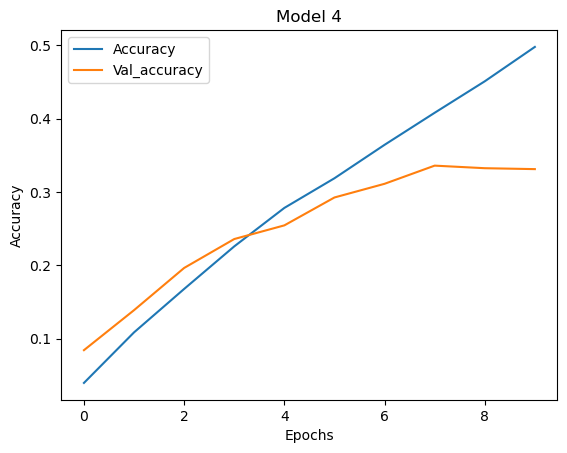

In [135]:
plt.plot(history4.history["accuracy"])
plt.plot(history4.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 4");

### Model 5

In [136]:
model5 = models.Sequential()

model5.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same",input_shape=(32, 32, 3)))
model5.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same"))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model5.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model5.add(layers.Conv2D(128, (3, 3),padding="same",kernel_regularizer=l2(0.001) ,activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.001)))
model5.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
model5.add(layers.Dense(100, activation='softmax'))

model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model5.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_139 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_140 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_141 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_142 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

In [137]:
history5 = model5.fit(x_subtrain, y_subtrain, batch_size=64, epochs=10,validation_split=0.2)


Epoch 1/10
500/500 [==============================] - 80s 156ms/step - loss: 4.7031 - accuracy: 0.0096 - val_loss: 4.6071 - val_accuracy: 0.0077
Epoch 2/10
500/500 [==============================] - 77s 154ms/step - loss: 4.6057 - accuracy: 0.0100 - val_loss: 4.6064 - val_accuracy: 0.0077
Epoch 3/10
500/500 [==============================] - 77s 155ms/step - loss: 4.6053 - accuracy: 0.0106 - val_loss: 4.6067 - val_accuracy: 0.0077
Epoch 4/10
500/500 [==============================] - 77s 154ms/step - loss: 4.6052 - accuracy: 0.0098 - val_loss: 4.6068 - val_accuracy: 0.0077
Epoch 5/10
500/500 [==============================] - 78s 155ms/step - loss: 4.6052 - accuracy: 0.0102 - val_loss: 4.6070 - val_accuracy: 0.0077
Epoch 6/10
500/500 [==============================] - 78s 157ms/step - loss: 4.6052 - accuracy: 0.0108 - val_loss: 4.6071 - val_accuracy: 0.0077
Epoch 7/10
500/500 [==============================] - 78s 155ms/step - loss: 4.6052 - accuracy: 0.0105 - val_loss: 4.6073 - val_ac

In [140]:
model5.save("model5.keras")

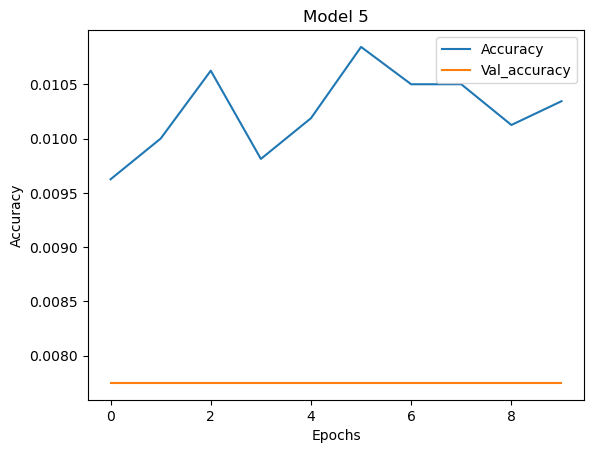

In [141]:
plt.plot(history5.history["accuracy"])
plt.plot(history5.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 5");

### Model6

In [144]:
model6 = models.Sequential()

model6.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same",input_shape=(32, 32, 3)))
model6.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same"))
model6.add(layers.BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model6.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model6.add(layers.BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(128, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model6.add(layers.Conv2D(128, (3, 3),padding="same",kernel_regularizer=l2(0.001) ,activation='relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.001)))
model6.add(layers.Dropout(0.25))
model6.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
model6.add(layers.Dropout(0.25))
model6.add(layers.Dense(100, activation='softmax'))

model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model6.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_151 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_152 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_55 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_153 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_154 (Conv2D)         (None, 16, 16, 64)      

In [145]:
history6 = model6.fit(x_subtrain, y_subtrain, batch_size=100, epochs=10,validation_split=0.2)


Epoch 1/10
320/320 [==============================] - 71s 217ms/step - loss: 4.9206 - accuracy: 0.0900 - val_loss: 4.5409 - val_accuracy: 0.0896
Epoch 2/10
320/320 [==============================] - 69s 217ms/step - loss: 3.8675 - accuracy: 0.1932 - val_loss: 3.8071 - val_accuracy: 0.2144
Epoch 3/10
320/320 [==============================] - 71s 221ms/step - loss: 3.5420 - accuracy: 0.2580 - val_loss: 3.6069 - val_accuracy: 0.2591
Epoch 4/10
320/320 [==============================] - 70s 219ms/step - loss: 3.3166 - accuracy: 0.3130 - val_loss: 3.5119 - val_accuracy: 0.2879
Epoch 5/10
320/320 [==============================] - 69s 215ms/step - loss: 3.1449 - accuracy: 0.3553 - val_loss: 3.3740 - val_accuracy: 0.3268
Epoch 6/10
320/320 [==============================] - 69s 217ms/step - loss: 3.0068 - accuracy: 0.3957 - val_loss: 3.2835 - val_accuracy: 0.3485
Epoch 7/10
320/320 [==============================] - 69s 216ms/step - loss: 2.8934 - accuracy: 0.4321 - val_loss: 3.3014 - val_ac

In [146]:
model6.save("model6.keras")

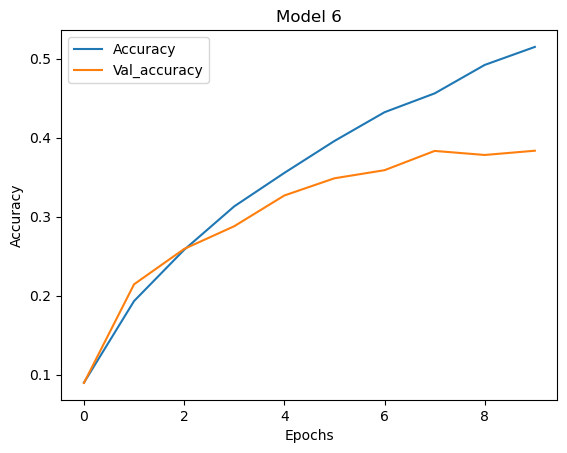

In [147]:
plt.plot(history6.history["accuracy"])
plt.plot(history6.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 6");

### Model7

In [ ]:
model7 = models.Sequential()

model7.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same",input_shape=(32, 32, 3)))
model7.add(layers.BatchNormalization())
model7.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same"))
model7.add(layers.BatchNormalization())
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model7.add(layers.BatchNormalization())
model7.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model7.add(layers.BatchNormalization())
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(128, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model7.add(layers.BatchNormalization())
model7.add(layers.Conv2D(128, (3, 3),padding="same",kernel_regularizer=l2(0.001) ,activation='relu'))
model7.add(layers.BatchNormalization())
model7.add(layers.Flatten())
model7.add(layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.001)))
model7.add(layers.Dropout(0.25))
model7.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
model7.add(layers.Dropout(0.25))
model7.add(layers.Dense(100, activation='softmax'))

model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model7.summary()

In [94]:
history7 = model7.fit(x_subtrain, y_subtrain, batch_size=100, epochs=10,validation_split=0.2)


Epoch 1/10
320/320 [==============================] - 81s 246ms/step - loss: 6.2530 - accuracy: 0.0865 - val_loss: 6.9420 - val_accuracy: 0.0226
Epoch 2/10
320/320 [==============================] - 78s 243ms/step - loss: 4.7560 - accuracy: 0.1952 - val_loss: 4.4839 - val_accuracy: 0.2289
Epoch 3/10
320/320 [==============================] - 78s 244ms/step - loss: 4.2267 - accuracy: 0.2808 - val_loss: 4.1621 - val_accuracy: 0.3072
Epoch 4/10
320/320 [==============================] - 78s 243ms/step - loss: 4.0048 - accuracy: 0.3514 - val_loss: 4.4855 - val_accuracy: 0.2889
Epoch 5/10
320/320 [==============================] - 76s 238ms/step - loss: 3.8711 - accuracy: 0.4067 - val_loss: 4.3630 - val_accuracy: 0.3324
Epoch 6/10
320/320 [==============================] - 76s 237ms/step - loss: 3.7959 - accuracy: 0.4543 - val_loss: 4.1331 - val_accuracy: 0.3936
Epoch 7/10
320/320 [==============================] - 76s 239ms/step - loss: 3.7092 - accuracy: 0.4964 - val_loss: 4.2182 - val_ac

In [95]:
model7.save("model7.keras")

In [153]:
plt.plot(history7.history["accuracy"])
plt.plot(history7.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 7");

KeyError: 'accuracy'

### Model8

In [149]:
model8 = models.Sequential()

model8.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same",input_shape=(32, 32, 3)))
model8.add(layers.BatchNormalization())
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
model8.add(layers.BatchNormalization())
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(128, (3, 3),padding="same",kernel_regularizer=l2(0.001) ,activation='relu'))
model8.add(layers.BatchNormalization())
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Flatten())
model8.add(layers.Dense(2048, activation='relu',kernel_regularizer=l2(0.001)))
model8.add(layers.Dropout(0.25))
model8.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
model8.add(layers.Dropout(0.25))
model8.add(layers.Dense(100, activation='softmax'))

model8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model8.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_157 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_57 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_158 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_58 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                     

In [150]:
history8 = model8.fit(x_subtrain, y_subtrain, batch_size=100, epochs=10,validation_split=0.2)


Epoch 1/10
320/320 [==============================] - 37s 111ms/step - loss: 5.7578 - accuracy: 0.0607 - val_loss: 5.5390 - val_accuracy: 0.0389
Epoch 2/10
320/320 [==============================] - 35s 111ms/step - loss: 4.1607 - accuracy: 0.1555 - val_loss: 4.1757 - val_accuracy: 0.1717
Epoch 3/10
320/320 [==============================] - 35s 109ms/step - loss: 3.7134 - accuracy: 0.2436 - val_loss: 3.5758 - val_accuracy: 0.2866
Epoch 4/10
320/320 [==============================] - 35s 110ms/step - loss: 3.5232 - accuracy: 0.3043 - val_loss: 3.6146 - val_accuracy: 0.3055
Epoch 5/10
320/320 [==============================] - 36s 112ms/step - loss: 3.3528 - accuracy: 0.3604 - val_loss: 3.7225 - val_accuracy: 0.2994
Epoch 6/10
320/320 [==============================] - 36s 111ms/step - loss: 3.2192 - accuracy: 0.4074 - val_loss: 3.4610 - val_accuracy: 0.3690
Epoch 7/10
320/320 [==============================] - 35s 109ms/step - loss: 3.1109 - accuracy: 0.4456 - val_loss: 3.5337 - val_ac

In [151]:
model8.save("model8.keras")

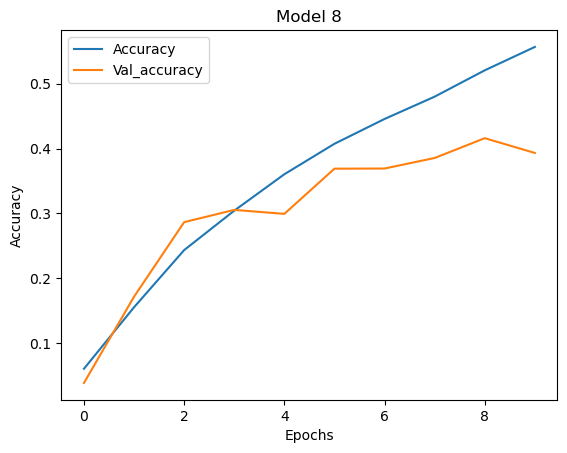

In [152]:
plt.plot(history8.history["accuracy"])
plt.plot(history8.history["val_accuracy"])
plt.legend(["Accuracy","Val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 8");

# Retraining and testing

In [154]:
#model 7
topmodel1 = models.Sequential()

topmodel1.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same",input_shape=(32, 32, 3)))
topmodel1.add(layers.BatchNormalization())
topmodel1.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same"))
topmodel1.add(layers.BatchNormalization())
topmodel1.add(layers.MaxPooling2D((2, 2)))
topmodel1.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
topmodel1.add(layers.BatchNormalization())
topmodel1.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
topmodel1.add(layers.BatchNormalization())
topmodel1.add(layers.MaxPooling2D((2, 2)))
topmodel1.add(layers.Conv2D(128, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
topmodel1.add(layers.BatchNormalization())
topmodel1.add(layers.Conv2D(128, (3, 3),padding="same",kernel_regularizer=l2(0.001) ,activation='relu'))
topmodel1.add(layers.BatchNormalization())
topmodel1.add(layers.Flatten())
topmodel1.add(layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.001)))
topmodel1.add(layers.Dropout(0.25))
topmodel1.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
topmodel1.add(layers.Dropout(0.25))
topmodel1.add(layers.Dense(100, activation='softmax'))

topmodel1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

new_history1 = topmodel1.fit(x_subtrain, y_subtrain, batch_size=100, epochs=15,validation_data=(x_val,y_val))

Epoch 1/15
400/400 [==============================] - 106s 259ms/step - loss: 6.0214 - accuracy: 0.0882 - val_loss: 5.4050 - val_accuracy: 0.0910
Epoch 2/15
400/400 [==============================] - 101s 251ms/step - loss: 4.5325 - accuracy: 0.2029 - val_loss: 4.1501 - val_accuracy: 0.2587
Epoch 3/15
400/400 [==============================] - 101s 252ms/step - loss: 4.0709 - accuracy: 0.2931 - val_loss: 4.1736 - val_accuracy: 0.3002
Epoch 4/15
400/400 [==============================] - 102s 255ms/step - loss: 3.8853 - accuracy: 0.3620 - val_loss: 3.9766 - val_accuracy: 0.3511
Epoch 5/15
400/400 [==============================] - 102s 255ms/step - loss: 3.7423 - accuracy: 0.4137 - val_loss: 3.9716 - val_accuracy: 0.3895
Epoch 6/15
400/400 [==============================] - 101s 253ms/step - loss: 3.6526 - accuracy: 0.4580 - val_loss: 3.8830 - val_accuracy: 0.4252
Epoch 7/15
400/400 [==============================] - 101s 253ms/step - loss: 3.5825 - accuracy: 0.4905 - val_loss: 4.1903 -

In [157]:
#model 8
topmodel2 = models.Sequential()

topmodel2.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same",input_shape=(32, 32, 3)))
topmodel2.add(layers.BatchNormalization())
topmodel2.add(layers.MaxPooling2D((2, 2)))
topmodel2.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
topmodel2.add(layers.BatchNormalization())
topmodel2.add(layers.MaxPooling2D((2, 2)))
topmodel2.add(layers.Conv2D(128, (3, 3),padding="same",kernel_regularizer=l2(0.001) ,activation='relu'))
topmodel2.add(layers.BatchNormalization())
topmodel2.add(layers.MaxPooling2D((2, 2)))
topmodel2.add(layers.Flatten())
topmodel2.add(layers.Dense(2048, activation='relu',kernel_regularizer=l2(0.001)))
topmodel2.add(layers.Dropout(0.25))
topmodel2.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
topmodel2.add(layers.Dropout(0.25))
topmodel2.add(layers.Dense(100, activation='softmax'))

topmodel2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

new_history2 = topmodel2.fit(x_subtrain, y_subtrain, batch_size=100, epochs=15,validation_data=(x_val,y_val))

Epoch 1/20
400/400 [==============================] - 48s 117ms/step - loss: 5.5261 - accuracy: 0.0644 - val_loss: 4.8343 - val_accuracy: 0.0595
Epoch 2/20
400/400 [==============================] - 46s 116ms/step - loss: 3.9893 - accuracy: 0.1775 - val_loss: 3.8350 - val_accuracy: 0.2193
Epoch 3/20
400/400 [==============================] - 47s 117ms/step - loss: 3.6098 - accuracy: 0.2661 - val_loss: 4.7924 - val_accuracy: 0.1685
Epoch 4/20
400/400 [==============================] - 47s 117ms/step - loss: 3.4112 - accuracy: 0.3329 - val_loss: 3.7462 - val_accuracy: 0.2939
Epoch 5/20
400/400 [==============================] - 47s 116ms/step - loss: 3.2668 - accuracy: 0.3852 - val_loss: 3.4009 - val_accuracy: 0.3636
Epoch 6/20
400/400 [==============================] - 47s 118ms/step - loss: 3.1286 - accuracy: 0.4277 - val_loss: 3.4141 - val_accuracy: 0.3766
Epoch 7/20
400/400 [==============================] - 49s 122ms/step - loss: 3.0239 - accuracy: 0.4651 - val_loss: 3.3273 - val_ac

In [159]:
#model 6
topmodel3 = models.Sequential()

topmodel3.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same",input_shape=(32, 32, 3)))
topmodel3.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001), padding="same"))
topmodel3.add(layers.BatchNormalization())
topmodel3.add(layers.MaxPooling2D((2, 2)))
topmodel3.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
topmodel3.add(layers.Conv2D(64, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
topmodel3.add(layers.BatchNormalization())
topmodel3.add(layers.MaxPooling2D((2, 2)))
topmodel3.add(layers.Conv2D(128, (3, 3),padding="same" ,kernel_regularizer=l2(0.001),activation='relu'))
topmodel3.add(layers.Conv2D(128, (3, 3),padding="same",kernel_regularizer=l2(0.001) ,activation='relu'))
topmodel3.add(layers.Flatten())
topmodel3.add(layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.001)))
topmodel3.add(layers.Dropout(0.25))
topmodel3.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
topmodel3.add(layers.Dropout(0.25))
topmodel3.add(layers.Dense(100, activation='softmax'))

topmodel3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


new_history3 = topmodel3.fit(x_subtrain, y_subtrain, batch_size=100, epochs=15,validation_data=(x_val,y_val))

Epoch 1/15
400/400 [==============================] - 91s 224ms/step - loss: 4.7565 - accuracy: 0.0983 - val_loss: 4.2011 - val_accuracy: 0.1309
Epoch 2/15
400/400 [==============================] - 88s 221ms/step - loss: 3.7818 - accuracy: 0.1971 - val_loss: 3.5960 - val_accuracy: 0.2358
Epoch 3/15
400/400 [==============================] - 88s 219ms/step - loss: 3.4467 - accuracy: 0.2682 - val_loss: 3.5575 - val_accuracy: 0.2597
Epoch 4/15
400/400 [==============================] - 87s 217ms/step - loss: 3.2222 - accuracy: 0.3183 - val_loss: 3.1729 - val_accuracy: 0.3353
Epoch 5/15
400/400 [==============================] - 87s 218ms/step - loss: 3.0528 - accuracy: 0.3663 - val_loss: 3.1647 - val_accuracy: 0.3551
Epoch 6/15
400/400 [==============================] - 87s 219ms/step - loss: 2.9259 - accuracy: 0.3982 - val_loss: 3.2145 - val_accuracy: 0.3576
Epoch 7/15
400/400 [==============================] - 88s 220ms/step - loss: 2.8279 - accuracy: 0.4314 - val_loss: 3.0522 - val_ac

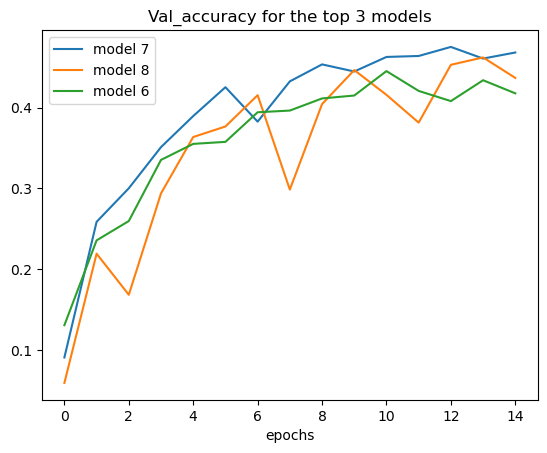

In [162]:
plt.plot(new_history1.history["val_accuracy"])
plt.plot(new_history2.history["val_accuracy"][0:15])
plt.plot(new_history3.history["val_accuracy"])
plt.legend(["model 7","model 8","model 6"])
plt.xlabel("epochs")
plt.title("Val_accuracy for the top 3 models");

In [161]:
topmodel1.evaluate(x=x_test,y=y_test) #model 8
topmodel2.evaluate(x=x_test,y=y_test) #model 7 
topmodel3.evaluate(x=x_test,y=y_test) #model 6

313/313 [==============================] - 8s 25ms/step - loss: 3.3584 - accuracy: 0.4133


[3.358365297317505, 0.4133000075817108]

In [163]:
topmodel1.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_160 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_60 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_161 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_61 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

In [164]:
topmodel2.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_168 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_66 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_169 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_67 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                     

In [165]:
topmodel3.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_177 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_178 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_71 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_179 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_180 (Conv2D)         (None, 16, 16, 64)      